# CSCI 576 Final Project - Match Videos with Object Detection
### author: tong wang

In [1]:
from imageai.Detection import ObjectDetection
from skimage import io
from skimage.color import rgb2gray
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from sys import getsizeof
from skimage.measure import shannon_entropy

Using TensorFlow backend.


## 0. Setup detectors
- you need to install imageai and its dependencies before running. Link: https://imageai.readthedocs.io/en/latest/index.html
- DON'T install tensorflow 2.0, install 1.x versions
- First time running will produce some warnings b/c some TF 1.0 methods are depreacated. It's fine.
- Resnet detector is commented out because it is too slow
- yoloCustom specify what objects should be detected. Some objects from all 80 possible objects are set to false because:
    - 'truck', 'bus', 'train' ... can all be considered as 'car'
    - some objects produces incorrect detection (e.g. motorcycle)
- detector.loadModel() **takes some time** (~10 seconds), but it only needed to be run once.

In [2]:
"""
There are 80 possible objects that you can detect with the
ObjectDetection class, and they are as seen below.

    person,   bicycle,   car,   motorcycle,   airplane,
    bus,   train,   truck,   boat,   traffic light,   fire hydrant,   stop_sign,
    parking meter,   bench,   bird,   cat,   dog,   horse,   sheep,   cow,   elephant,   bear,   zebra,
    giraffe,   backpack,   umbrella,   handbag,   tie,   suitcase,   frisbee,   skis,   snowboard,
    sports ball,   kite,   baseball bat,   baseball glove,   skateboard,   surfboard,   tennis racket,
    bottle,   wine glass,   cup,   fork,   knife,   spoon,   bowl,   banana,   apple,   sandwich,   orange,
    broccoli,   carrot,   hot dog,   pizza,   donot,   cake,   chair,   couch,   potted plant,   bed,
    dining table,   toilet,   tv,   laptop,   mouse,   remote,   keyboard,   cell phone,   microwave,
    oven,   toaster,   sink,   refrigerator,   book,   clock,   vase,   scissors,   teddy bear,   hair dryer,
    toothbrush.

To detect only some of the objects above, you will need to call the CustomObjects function and set the name of the
object(s) yiu want to detect to through. The rest are False by default. 
"""

# resnetDetector = ObjectDetection()
# resnetDetector.setModelTypeAsRetinaNet()
# resnetDetector.setModelPath("resnet50_coco_best_v2.0.1.h5")
# resnetCustom = resnetDetector.CustomObjects(truck=False, bus=False, train=False, motorcycle=False)
# resnetDetector.loadModel()

yoloDetector = ObjectDetection()
yoloDetector.setModelTypeAsYOLOv3()
yoloDetector.setModelPath("yolo.h5")
yoloCustom = yoloDetector.CustomObjects(truck=False, bus=False, train=False, motorcycle=False,
                                        person=True, suitcase=True, tie=False, car=True,
                                        chair=True, couch=True, potted_plant=True, refrigerator=True,
                                        stop_sign=True, bench=True,   bird=True,   cat=True,   
                                        dog=True,   horse=True,   sheep=True,   cow=True,   
                                        elephant=True,   bear=True,   zebra=True, giraffe=True,   
                                        backpack=True,   umbrella=True,   handbag=True,frisbee=True,   
                                        skis=True,   snowboard=True, bottle=True,   wine_glass=True,   
                                        cup=True, fork=True,   knife=True,   spoon=True,
                                        bowl=True,   banana=True, apple=True,   sandwich=True, 
                                        orange=True, broccoli=True, carrot=True,   hot_dog=True, 
                                        pizza=True,  cake=True, bed=True,     dining_table=True, 
                                        toilet=True,   tv=True,   laptop=True,   mouse=True,   
                                        remote=True,   keyboard=True,   cell_phone=True,   microwave=True, 
                                        oven=True,  toaster=True,   sink=True, book=True,   
                                        clock=True,   vase=True,   scissors=True,   teddy_bear=True,   
                                        hair_dryer=True, toothbrush=True, boat=True,   traffic_light=True,  
                                        fire_hydrant=True)
yoloDetector.loadModel()














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 1. read query videos and store them as list of image arrays of shape (288, 352, 3)
- Same as in color matching part

In [4]:
# read one rgb img
def readRGBimg(path_to_file, filename):
    byte_list = []
    with open(path_to_file+filename, "rb") as f:
        byte = f.read(1)
        while byte != b"":
            byte_list.append(byte)
            byte = f.read(1)

    img_data = np.zeros((288,352,3)).astype(np.uint8)
    height = 288
    width = 352
    ind = 0
    for y in range(height):
        for x in range(width):
            a=0
            r=int.from_bytes(byte_list[ind], byteorder='big')
            g=int.from_bytes(byte_list[ind+height*width], byteorder='big')
            b=int.from_bytes(byte_list[ind+height*width*2], byteorder='big')

            img_data[y][x][0] = r;
            img_data[y][x][1] = g;
            img_data[y][x][2] = b;

            ind+=1
    return img_data

# generate num_files # of filenames as format fnString+(001,002,...,150)+fileformat(.rgb)
def generateFileNames(num_files, fnString, fileformat):
    retFileNames = []
    for i in range(1, num_files + 1, 1):
        if (i<10):
            fnStr = "00"+str(i)
        elif (i<100):
            fnStr = "0"+str(i)
        else:
            fnStr = str(i)
        currRetName = fnString+fnStr+fileformat
        retFileNames.append(currRetName)
    return retFileNames

# reads a folder of query video images that of .rgb format
# returns list of 150 images array, each of shape (288, 352, 3)
def readRGBvideo(path_to_file, fnString, num_files):
    retImgsList = []
    filenamesList = generateFileNames(num_files, fnString, ".rgb")
    for i in range (num_files):
        retImgsList.append(readRGBimg(path_to_file,filenamesList[i]))
    return retImgsList

In [4]:
# read and store new uploaded SeenExactMatch query videos.
# takes about 90s. 30s each.

num_files = 150

path_to_file = "./query_videos/SeenExactMatch/Q3/"
fnString = "Q3_"
Q3query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(Q3query)/64, "MB of memory")

path_to_file = "./query_videos/SeenExactMatch/Q4/"
fnString = "Q4_"
Q4query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(Q4query)/64, "MB of memory")

path_to_file = "./query_videos/SeenExactMatch/Q5/"
fnString = "Q5_"
Q5query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(Q5query)/64, "MB of memory")

Q3_ query video takes 22.75 MB of memory
Q4_ query video takes 22.75 MB of memory
Q5_ query video takes 22.75 MB of memory


In [5]:
# read and store new uploaded SeenInexactMatch query videos.
# takes about 90s. 30s each.

num_files = 150

path_to_file = "./query_videos/SeenInexactMatch/HQ1/"
fnString = "HQ1_"
HQ1query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(HQ1query)/64, "MB of memory")

path_to_file = "./query_videos/SeenInexactMatch/HQ2/"
fnString = "HQ2_"
HQ2query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(HQ2query)/64, "MB of memory")

path_to_file = "./query_videos/SeenInexactMatch/HQ4/"
fnString = "HQ4_"
HQ4query = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(HQ4query)/64, "MB of memory")

HQ1_ query video takes 22.75 MB of memory
HQ2_ query video takes 22.75 MB of memory
HQ4_ query video takes 22.75 MB of memory


In [5]:
# read old query videos

num_files = 150

path_to_file = "./query_videos/first/"
fnString = "first"
firstquery = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(firstquery)/64, "MB of memory")

path_to_file = "./query_videos/second/"
fnString = "second"
secondquery = readRGBvideo(path_to_file, fnString, num_files)
print(fnString,"query video takes",getsizeof(secondquery)/64, "MB of memory")

first query video takes 22.75 MB of memory
second query video takes 22.75 MB of memory


## 2. read database videos and store them as list of image arrays of shape (288, 352, 3)
- DIFFERENT from color matching part. But the only difference is below cells only load data frames from local .jpg files
- runs **very fast** b/c no .rgb to .jpg conversion
- loaded videos (i.e. xxxVid) are list of 600 frames, each frame has size  (288, 352, 3) (same convention with query videos)

In [7]:
def readJPGvideo(path_to_file, fnString, num_files):
    retImgsList = []
    filenamesList = generateFileNames(num_files, fnString, ".jpg")
    for i in range(num_files):
        currImg = io.imread(path_to_file+filenamesList[i])
        retImgsList.append(currImg)
    return retImgsList

num_files = 600

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGflowers/"
fnString = "flowers"
flowersVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGinterview/"
fnString = "interview"
interviewVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGmovie/"
fnString = "movie"
movieVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGmusicvideo/"
fnString = "musicvideo"
musicvideoVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGsports/"
fnString = "sports"
sportsVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGstarcraft/"
fnString = "starcraft"
starcraftVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

path_to_file = "./CS576FinalProjData/JPGdatabase_videos/JPGtraffic/"
fnString = "traffic"
trafficVid = readJPGvideo(path_to_file, fnString, num_files)
print(fnString,"data video takes",getsizeof(flowersVid)/64, "MB of memory")

flowers data video takes 86.0 MB of memory
interview data video takes 86.0 MB of memory
movie data video takes 86.0 MB of memory
musicvideo data video takes 86.0 MB of memory
sports data video takes 86.0 MB of memory
starcraft data video takes 86.0 MB of memory
traffic data video takes 86.0 MB of memory


## 3. Object Detection
### 3.1 Simple Run (to test if you installed imageai correctly)

detections: [{'name': 'person', 'percentage_probability': 96.25985622406006, 'box_points': [66, 169, 117, 288]}, {'name': 'person', 'percentage_probability': 99.95410442352295, 'box_points': [99, 7, 290, 284]}]
person 96.25985622406006
person 99.95410442352295


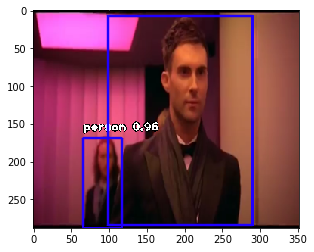

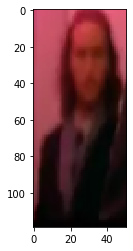

In [6]:
returned_image, detections, extracted_objects = yoloDetector.detectCustomObjectsFromImage(
                                                                            custom_objects=yoloCustom,
                                                                            input_image=firstquery[134], 
                                                                            output_type="array", 
                                                                            minimum_percentage_probability=55, 
                                                                            input_type="array",
                                                                            #display_percentage_probability=False,
                                                                            #display_object_name=False,
                                                                            extract_detected_objects=True
                                                                                     )
print("detections:",detections)
for d in detections:
    print(d["name"], d["percentage_probability"])

plt.imshow(returned_image)
plt.show()
plt.imshow(extracted_objects[0])
plt.show()

### 3.1 Utilities
- findKeyFrames() takes list frames loaded by seciont 1. and 2. and find keyframes from the list of frames. It reduces a video to a 1d array of size num_frames (e.g. 150 for query). Each value in the array is the absolute difference between certain frame (grayscaled, so size is (288,352)) and its previous frame (for the very first frame, the value is first_frame - img_with_all_0s). **keyframes = np.argwhere(result > mean+std)** means only values greater than mean_of_all_difference_value+std_dev are considered as keyframes. This functions returns:
    - keyframes: array of numbers. each number is a position of a keyframe in video
    - result: initial inter-frame difference values (1d array as mentioned above). Would be used by plotFrameDiff1DArray()

- checkInterframeEntropyDiff(img1, img2) does the same thing as it in color matching part, but threshold is **much larger** (0.1 instead of 0.03)

- plotFrameDiff1DArray(keyframes_1d_result) plot the interframe difference array returned by findKeyframes() (i.e. result, see below) before extracting keyframes. It is only used for visualization purpose. The peaks from the resulting graph are basically the keyframes found by findKeyframes()

In [9]:
def findKeyframes(list_of_frames):
    # calculate keyframes by getting F by F difference
    result = []
    for i in range(len(list_of_frames)):
        if (i==0):
            prevImg = np.zeros((288, 352))
            currImg = rgb2gray(list_of_frames[i])
        else:
            prevImg = rgb2gray(list_of_frames[i])
            currImg = rgb2gray(list_of_frames[i-1])
        # use the fact that 1-norm is the absolute difference. Fucking fast.
        frameDiff = cv2.norm(currImg, prevImg, cv2.NORM_L1)
        result.append(frameDiff)
    result = np.asarray(result)
    mean = np.mean(result)
    std = np.std(result)
    keyframes = np.argwhere(result > mean+std)
    keyframes = keyframes.reshape(-1,len(keyframes))[0]
    
    # clean up keyframes by entropy checking
    delete_ind = []
    for i in range(len(keyframes)):
        if (i==len(keyframes) - 1):
            break
        if(checkInterframeEntropyDiff(list_of_frames[keyframes[i]], list_of_frames[keyframes[i+1]]) == False):
            delete_ind.append(i+1)
    keyframes = np.delete(keyframes, delete_ind)
    return keyframes, result # result is F by F diff differnce array, return this just for plot

def checkInterframeEntropyDiff(img1, img2):
    entropyDiff = abs(shannon_entropy(img1) - shannon_entropy(img2))
    if (entropyDiff > 0.1):
        return True
    else:
        return False
    
def plotFrameDiff1DArray(keyframes_1d_result):
    print("Frame difference analysis graph: ")
    plt.plot(keyframes_1d_result)
    plt.show()

### 3.2 Finally, detection
- **query_video_object_detection(list_of_frames)** only detect objects from calculated keyframes. **data_video_object_detection(list_of_frames)** not only detect objects from calculated keyframes, but also considers one frame prior to any keyframes a as a keyframe for object detection b/c sometimes the previous keyframe are not stored due to statistical reason (i.e. 600 frames has too much information, something frame that would be a keyframe with 150 frames video are just ignored by 600 frames data. One example is 'suitcase' will be missed for mv data video if not considering frames prior to keyframes a as keyframes. Also, this is only done in data video b/c time is not a concern and we want accurate detection.

In [13]:
# detect objects from one image
def img_object_detection(img):
    
    currRetImg, img_detections, extracted_objects = yoloDetector.detectCustomObjectsFromImage(
                                                                                custom_objects=yoloCustom,
                                                                                input_image=img, 
                                                                                output_type="array", 
                                                                                minimum_percentage_probability=55, 
                                                                                input_type="array",
                                                                                display_percentage_probability=False,
                                                                                display_object_name=False,
                                                                                extract_detected_objects=True)
    img_detected_names = []
    for detectedObject in img_detections:
        img_detected_names.append(detectedObject["name"])
    objectName, _img_obj_counts = np.unique(img_detected_names, return_counts=True)
    return objectName
    

# detect objects from a query video
def query_video_object_detection(list_of_frames):
    keyframes, keyframes_visualization = findKeyframes(list_of_frames)
#     print(keyframes)
    video_detected_obj_names = []
    for i in range(len(keyframes)):
        currKeyframe = list_of_frames[keyframes[i]]

        objectName = img_object_detection(currKeyframe)
        for name in objectName:
            if (name=='tie'):
                print(keyframes[i],"fuck")
            video_detected_obj_names.append(name)

    video_detected_obj_names, _ = np.unique(video_detected_obj_names, return_counts=True)
    return video_detected_obj_names, keyframes_visualization

# detect objects from a data video
def data_video_object_detection(list_of_frames):
    keyframes, keyframes_visualization = findKeyframes(list_of_frames)
#     print(keyframes)
    video_detected_obj_names = []
    for i in range(len(keyframes)):
        currKeyframe = list_of_frames[keyframes[i]]

        objectName = img_object_detection(currKeyframe)
        for name in objectName:
            if (name=='train'):
                print(keyframes[i],"fuck")
            video_detected_obj_names.append(name)
        
        # also consider one frame prior to current keyframe as a keyframe
        if (keyframes[i]>0):
            prevFrame = list_of_frames[keyframes[i]-1]
            objectName2 = img_object_detection(prevFrame)
            for name in objectName2:
                video_detected_obj_names.append(name)

    video_detected_obj_names, _ = np.unique(video_detected_obj_names, return_counts=True)
    return video_detected_obj_names, keyframes_visualization

mv query detected objects ['person' 'suitcase']
Frame difference analysis graph: 


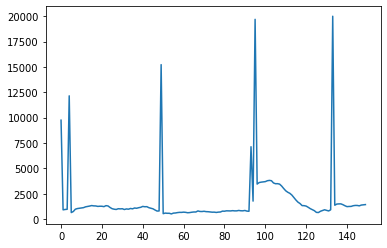

sports query detected objects ['person']
Frame difference analysis graph: 


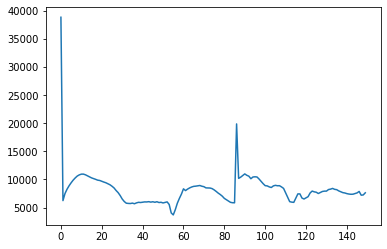

traffic query detected objects ['car']
Frame difference analysis graph: 


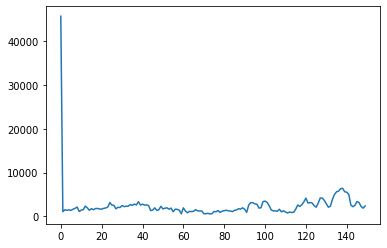

starcraft query detected objects ['person']
Frame difference analysis graph: 


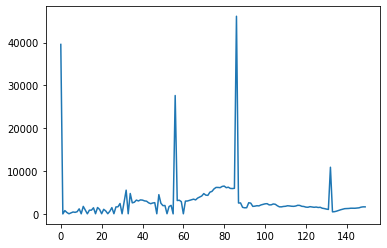

flower query detected objects []
Frame difference analysis graph: 


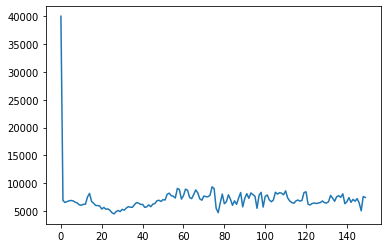

Look like a movie query detected objects ['person']
Frame difference analysis graph: 


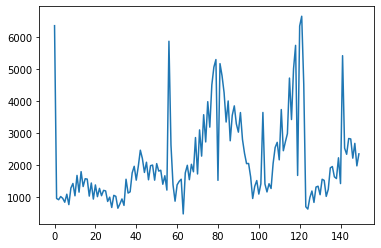

Cars with hight motion query detected objects ['car' 'person']
Frame difference analysis graph: 


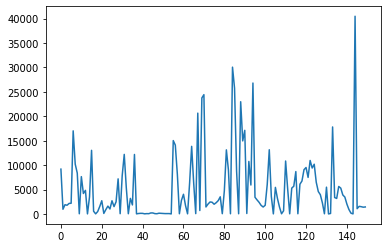

Other flowers query detected objects ['car' 'person']
Frame difference analysis graph: 


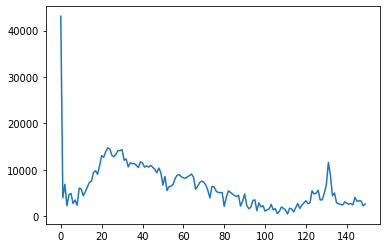

In [11]:
mvQueryDetect, mvKeyframesVis = query_video_object_detection(firstquery)
print("mv query detected objects",mvQueryDetect)
plotFrameDiff1DArray(mvKeyframesVis)

sportsQueryDetect, sportsKeyframesVis = query_video_object_detection(secondquery)
print("sports query detected objects",sportsQueryDetect)
plotFrameDiff1DArray(sportsKeyframesVis)

trafficQueryDetect, trafficKeyframesVis = query_video_object_detection(Q3query)
print("traffic query detected objects",trafficQueryDetect)
plotFrameDiff1DArray(trafficKeyframesVis)

starcraftQueryDetect, starcraftKeyframesVis = query_video_object_detection(Q4query)
print("starcraft query detected objects",starcraftQueryDetect)
plotFrameDiff1DArray(starcraftKeyframesVis)

flowerQueryDetect, flowerKeyframesVis = query_video_object_detection(Q5query)
print("flower query detected objects",flowerQueryDetect)
plotFrameDiff1DArray(flowerKeyframesVis)

HQ1QueryDetect, HQ1KeyframesVis = query_video_object_detection(HQ1query)
print("Look like a movie query detected objects",HQ1QueryDetect)
plotFrameDiff1DArray(HQ1KeyframesVis)

HQ2QueryDetect, HQ2KeyframesVis = query_video_object_detection(HQ2query)
print("Cars with hight motion query detected objects",HQ2QueryDetect)
plotFrameDiff1DArray(HQ2KeyframesVis)

HQ4QueryDetect, HQ4KeyframesVis = query_video_object_detection(HQ4query)
print("Other flowers query detected objects",HQ4QueryDetect)
plotFrameDiff1DArray(HQ4KeyframesVis)

flowers data detected objects ['car']
Frame difference analysis graph: 


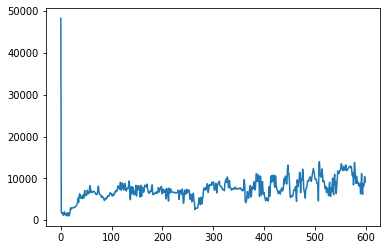

interview data detected objects ['chair' 'couch' 'person' 'potted plant']
Frame difference analysis graph: 


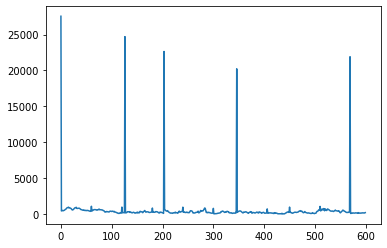

movie data detected objects ['person' 'refrigerator']
Frame difference analysis graph: 


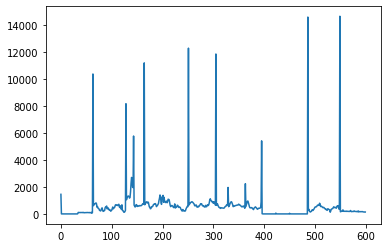

mv data detected objects ['person' 'suitcase']
Frame difference analysis graph: 


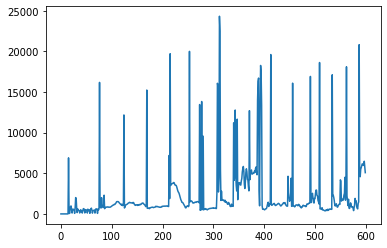

sports data detected objects ['person']
Frame difference analysis graph: 


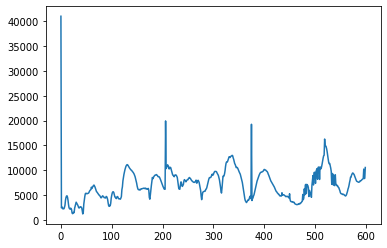

starcraft data detected objects ['person']
Frame difference analysis graph: 


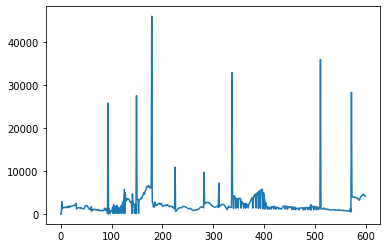

traffic data detected objects ['car']
Frame difference analysis graph: 


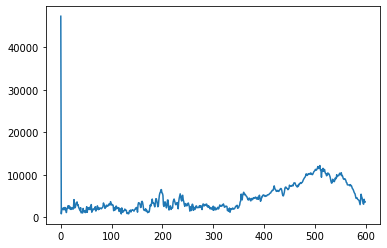

In [14]:
flowersDataDetect, flowerDataKeyframeVis = data_video_object_detection(flowersVid)
print("flowers data detected objects", flowersDataDetect)
plotFrameDiff1DArray(flowerDataKeyframeVis)

interviewDataDetect, interviewDataKeyframeVis = data_video_object_detection(interviewVid)
print("interview data detected objects", interviewDataDetect)
plotFrameDiff1DArray(interviewDataKeyframeVis)

movieDataDetect, movieDataKeyframeVis = data_video_object_detection(movieVid)
print("movie data detected objects", movieDataDetect)
plotFrameDiff1DArray(movieDataKeyframeVis)

mvDataDetect, mvDataKeyframeVis = data_video_object_detection(musicvideoVid)
print("mv data detected objects", mvDataDetect)
plotFrameDiff1DArray(mvDataKeyframeVis)

sportsDataDetect, sportsDataKeyframeVis = data_video_object_detection(sportsVid)
print("sports data detected objects", sportsDataDetect)
plotFrameDiff1DArray(sportsDataKeyframeVis)

starcraftDataDetect, starcraftDataKeyframeVis = data_video_object_detection(starcraftVid)
print("starcraft data detected objects", starcraftDataDetect)
plotFrameDiff1DArray(starcraftDataKeyframeVis)

trafficDataDetect, trafficDataKeyframeVis = data_video_object_detection(trafficVid)
print("traffic data detected objects", trafficDataDetect)
plotFrameDiff1DArray(trafficDataKeyframeVis)

## 4. Final matching results
- calcObjDetMatchScore(queryObjArr, dataObjArr) calculates overlap between two array of objects by converting arrays to two set and calculating **intersection(queryObjSet, dataObjSet) / max(len(dataObjArr),len(queryObjArr))**

In [15]:
def calcObjDetMatchScore(queryObjArr, dataObjArr):
    common = set(queryObjArr).intersection(set(dataObjArr))
    match_score = len(common) / max(len(dataObjArr),len(queryObjArr))
    return np.around(match_score*100, decimals=2)

def obj_det_matchQueryWithDatabase(query_name, queryObjArr):
    if (len(queryObjArr) == 0):
        print("No object detected for the input",query_name,"\n")
    else:
        print(query_name, "objects detected:",queryObjArr)
        print(query_name, "against flowers matching score:", calcObjDetMatchScore(queryObjArr, flowersDataDetect), "%")
        print(query_name, "against interview matching score:", calcObjDetMatchScore(queryObjArr, interviewDataDetect) ,"%")
        print(query_name, "against movie matching score:", calcObjDetMatchScore(queryObjArr, movieDataDetect) ,"%")
        print(query_name, "against MV matching score:", calcObjDetMatchScore(queryObjArr, mvDataDetect) ,"%")
        print(query_name, "against sports matching score:", calcObjDetMatchScore(queryObjArr, sportsDataDetect) ,"%")
        print(query_name, "against starcraft matching score:", calcObjDetMatchScore(queryObjArr, starcraftDataDetect) ,"%")
        print(query_name, "against traffic matching score:", calcObjDetMatchScore(queryObjArr, trafficDataDetect) ,"%")
        print("\n")
    
obj_det_matchQueryWithDatabase("MV query", mvQueryDetect)
obj_det_matchQueryWithDatabase("Sports query", sportsQueryDetect)
obj_det_matchQueryWithDatabase("Traffic query", trafficQueryDetect)
obj_det_matchQueryWithDatabase("Starcraft query", starcraftQueryDetect)
obj_det_matchQueryWithDatabase("Flowers query", flowerQueryDetect)
obj_det_matchQueryWithDatabase("Look like a movie query", HQ1QueryDetect)
obj_det_matchQueryWithDatabase("Cars with hight motion query", HQ2QueryDetect)
obj_det_matchQueryWithDatabase("Other flowers but with some cars query", HQ4QueryDetect)

MV query objects detected: ['person' 'suitcase']
MV query against flowers matching score: 0.0 %
MV query against interview matching score: 25.0 %
MV query against movie matching score: 50.0 %
MV query against MV matching score: 100.0 %
MV query against sports matching score: 50.0 %
MV query against starcraft matching score: 50.0 %
MV query against traffic matching score: 0.0 %


Sports query objects detected: ['person']
Sports query against flowers matching score: 0.0 %
Sports query against interview matching score: 25.0 %
Sports query against movie matching score: 50.0 %
Sports query against MV matching score: 50.0 %
Sports query against sports matching score: 100.0 %
Sports query against starcraft matching score: 100.0 %
Sports query against traffic matching score: 0.0 %


Traffic query objects detected: ['car']
Traffic query against flowers matching score: 100.0 %
Traffic query against interview matching score: 0.0 %
Traffic query against movie matching score: 0.0 %
Traffic query ag